refer to https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Using TensorFlow backend.


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0669 - val_loss: 0.0564
Epoch 2/50
 - 0s - loss: 0.0446 - val_loss: 0.0607
Epoch 3/50
 - 1s - loss: 0.0296 - val_loss

<Figure size 640x480 with 1 Axes>

In [31]:
# make a prediction
yhat = model.predict(test_X)
print('yhat.shape', yhat.shape, yhat[0:5, :])
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X_reshape.shape, test_X_reshape[0:5, -7:])
      
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print('inv_yhat.shape', inv_yhat.shape, inv_yhat[0:5, :])

inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# 因为inv_y 预测是下一时刻的值，所以需要把 inv_yhat 往后 shift 一个时刻
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

yhat.shape (35039, 1) [[0.03471613]
 [0.0311703 ]
 [0.02050942]
 [0.01929277]
 [0.01892459]]
(35039, 8) [[0.33823532 0.1967213  0.83636475 0.33333334 0.12757413 0.
  0.        ]
 [0.33823532 0.1967213  0.83636475 0.         0.006101   0.
  0.        ]
 [0.33823532 0.1967213  0.83636475 0.         0.0145091  0.
  0.        ]
 [0.32352942 0.18032786 0.83636475 0.33333334 0.006101   0.
  0.        ]
 [0.32352942 0.18032786 0.83636475 0.         0.006101   0.
  0.        ]]
inv_yhat.shape (35039, 8) [[ 3.4507835e+01 -1.7000000e+01 -7.0000000e+00  1.0370000e+03
   1.0000000e+00  7.5099998e+01  0.0000000e+00  0.0000000e+00]
 [ 3.0983276e+01 -1.7000000e+01 -7.0000000e+00  1.0370000e+03
   0.0000000e+00  4.0200000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.0386366e+01 -1.7000000e+01 -7.0000000e+00  1.0370000e+03
   0.0000000e+00  8.9399996e+00  0.0000000e+00  0.0000000e+00]
 [ 1.9177015e+01 -1.8000000e+01 -8.0000000e+00  1.0370000e+03
   1.0000000e+00  4.0200000e+00  0.0000000e+00  0.0000000e+00]

(35037, 24)


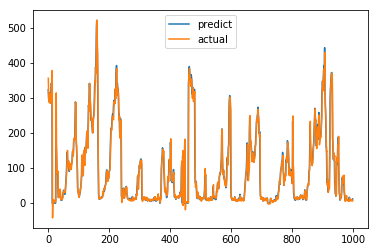

In [46]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y[-1000:], label='predict')
pyplot.plot( inv_yhat[-1000:], label='actual')
pyplot.legend()
pyplot.show()

## Multivariat with Multiple Lag Timesteps

(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 1s - loss: 0.0630 - val_loss: 0.0588
Epoch 2/50
 - 1s - loss: 0.0326 - val_loss: 0.0447
Epoch 3/50
 - 1s - loss: 0.0215 - val_loss: 0.0234
Epoch 4/50
 - 1s - loss: 0.0214 - val_loss: 0.0233
Epoch 5/50
 - 1s - loss: 0.0207 - val_loss: 0.0208
Epoch 6/50
 - 1s - loss: 0.0208 - val_loss: 0.0199
Epoch 7/50
 - 1s - loss: 0.0199 - val_loss: 0.0187
Epoch 8/50
 - 1s - loss: 0.0197 - val_loss: 0.0184
Epoch 9/50
 - 1s - loss: 0.0191 - val_loss: 0.0179
Epoch 10/50
 - 1s - loss: 0.0188 - val_loss: 0.0176
Epoch 11/50
 - 1s - loss: 0.0181 - val_loss: 0.0177
Epoch 12/50
 - 1s - loss: 0.0181 - val_loss: 0.0177
Epoch 13/50
 - 1s - loss: 0.0174 - val_loss: 0.0173
Epoch 14/50
 - 1s - loss: 0.0172 - val_loss: 0.0180
Epoch 15/50
 - 1s - loss: 0.0168 - val_loss: 0.0175
Epoch 16/50
 - 1s - loss: 0.0164 - val_loss: 0.0166
Epoch 17/50
 - 1s - loss: 0.0161 - val_loss: 0.0

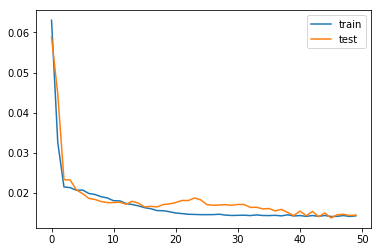

Test RMSE: 26.921


In [34]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [35]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.182


(35037, 24)


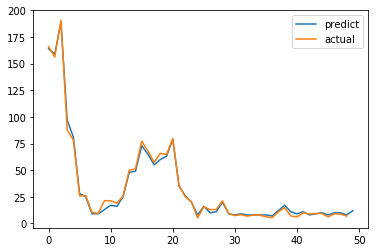

In [36]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y[-50:], label='predict')
pyplot.plot( inv_yhat[-49:], label='actual')
pyplot.legend()
pyplot.show()

In [39]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
print(scaled.shape)
print(scaled[0:5, :])
print('--------------')
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
print(reframed.head())

(43800, 8)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]]
--------------
(43797, 32)
   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)   ...     var7(t-1)  va